## For random testing 

In [31]:
a = [[1,2,3],[4,5,6]]


In [32]:
import numpy as np

In [33]:
a = np.matrix('1 2 4; 3 4 5')
a.shape

(2, 3)

b = np.array([[1,2,3],[2,3,4]])
c = np.array([1,3])
b.sum(axis=0)

In [34]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [35]:
np.sum([[0, 1], [0, 5]], axis=1)

array([1, 5])

In [36]:
import pandas as pd

In [37]:
titanic = pd.read_csv("../data/titanic_train.csv")

In [38]:
titanic.head()
print(titanic[pd.core.series.Series.notnull(titanic.Embarked)])
print(titanic.dtypes)

     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
5              6         0       3   
6              7         0       1   
7              8         0       3   
8              9         1       3   
9             10         1       2   
10            11         1       3   
11            12         1       1   
12            13         0       3   
13            14         0       3   
14            15         0       3   
15            16         1       2   
16            17         0       3   
17            18         1       2   
18            19         0       3   
19            20         1       3   
20            21         0       2   
21            22         1       2   
22            23         1       3   
23            24         1       1   
24            25         0       3   
25          

In [39]:
r"C:\Users\Bob\SecretPasswordFile.txt"

'C:\\Users\\Bob\\SecretPasswordFile.txt'

In [40]:
del titanic['PassengerId']
print(titanic)

     Survived  Pclass                                               Name  \
0           0       3                            Braund, Mr. Owen Harris   
1           1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2           1       3                             Heikkinen, Miss. Laina   
3           1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4           0       3                           Allen, Mr. William Henry   
5           0       3                                   Moran, Mr. James   
6           0       1                            McCarthy, Mr. Timothy J   
7           0       3                     Palsson, Master. Gosta Leonard   
8           1       3  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)   
9           1       2                Nasser, Mrs. Nicholas (Adele Achem)   
10          1       3                    Sandstrom, Miss. Marguerite Rut   
11          1       1                           Bonnell, Miss. Elizabeth   
12          

In [41]:
titanic.describe()
titanic[titanic.Survived == 1].describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,342.0,342.000000,290.000000,342.000000,342.000000,342.000000
mean,1.0,1.950292,28.343690,0.473684,0.464912,48.395408
std,0.0,0.863321,14.950952,0.708688,0.771712,66.596998
min,1.0,1.000000,0.420000,0.000000,0.000000,0.000000
25%,1.0,1.000000,19.000000,0.000000,0.000000,12.475000
50%,1.0,2.000000,28.000000,0.000000,0.000000,26.000000
75%,1.0,3.000000,36.000000,1.000000,1.000000,57.000000
max,1.0,3.000000,80.000000,4.000000,5.000000,512.329200


In [42]:
titanic[titanic.Survived == 0].head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


In [43]:
import matplotlib.pyplot as plt

In [44]:
a = titanic[(titanic.Survived == 1) & (titanic.Sex == "male")]
#a = a[a.Sex == "male"]
b = titanic[(titanic.Survived == 1) & (titanic.Sex == "female")]
#b = b[b.Sex == "female"]

In [45]:
y = [len(a),len(b)]

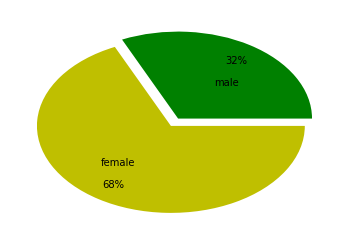

In [46]:
plt.pie(y,labels=["male","female"],labeldistance=0.5,colors=["g","y"], autopct='%1.0f%%',pctdistance=0.8,explode=[0,0.1])
plt.show()

In [47]:
print((titanic.Survived == 1).sum())

342


In [48]:
titanic[titanic.Sex == "male"]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
12,0,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,8.0500,NaN,S
13,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S
16,0,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29.1250,NaN,Q
17,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
20,0,2,"Fynney, Mr. Joseph J",male,35.0,0,0,239865,26.0000,NaN,S


In [49]:
t = titanic
print(type(t))
t[(t.Sex=="male") & (t.Survived == 1)]

<class 'pandas.core.frame.DataFrame'>


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
17,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
21,1,2,"Beesley, Mr. Lawrence",male,34.00,0,0,248698,13.0000,D56,S
23,1,1,"Sloper, Mr. William Thompson",male,28.00,0,0,113788,35.5000,A6,S
36,1,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,NaN,C
55,1,1,"Woolner, Mr. Hugh",male,NaN,0,0,19947,35.5000,C52,S
65,1,3,"Moubarek, Master. Gerios",male,NaN,1,1,2661,15.2458,NaN,C
74,1,3,"Bing, Mr. Lee",male,32.00,0,0,1601,56.4958,NaN,S
78,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S
81,1,3,"Sheerlinck, Mr. Jan Baptist",male,29.00,0,0,345779,9.5000,NaN,S
97,1,1,"Greenfield, Mr. William Bertram",male,23.00,0,1,PC 17759,63.3583,D10 D12,C


In [50]:
a = np.ones((1,4,3))
#print("a = ",a)
b = np.ones((4,3,8))
#print("b = ",b)
print(np.matmul(a,b))
print("Shape is ",np.matmul(a,b).shape)
#sum(a[0,1,:] * b[0,:,1])

[[[ 3.  3.  3.  3.  3.  3.  3.  3.]
  [ 3.  3.  3.  3.  3.  3.  3.  3.]
  [ 3.  3.  3.  3.  3.  3.  3.  3.]
  [ 3.  3.  3.  3.  3.  3.  3.  3.]]

 [[ 3.  3.  3.  3.  3.  3.  3.  3.]
  [ 3.  3.  3.  3.  3.  3.  3.  3.]
  [ 3.  3.  3.  3.  3.  3.  3.  3.]
  [ 3.  3.  3.  3.  3.  3.  3.  3.]]

 [[ 3.  3.  3.  3.  3.  3.  3.  3.]
  [ 3.  3.  3.  3.  3.  3.  3.  3.]
  [ 3.  3.  3.  3.  3.  3.  3.  3.]
  [ 3.  3.  3.  3.  3.  3.  3.  3.]]

 [[ 3.  3.  3.  3.  3.  3.  3.  3.]
  [ 3.  3.  3.  3.  3.  3.  3.  3.]
  [ 3.  3.  3.  3.  3.  3.  3.  3.]
  [ 3.  3.  3.  3.  3.  3.  3.  3.]]]
Shape is  (4, 4, 8)


In [51]:
a = np.array([1,2,3])
b = np.array([1,1,1])
a-b

array([0, 1, 2])

In [52]:
import pandas as pd
import numpy as np
import sklearn.datasets as Datasets
import sklearn.model_selection as cv
import matplotlib.pyplot as plt

In [53]:
def fitNormal(X_train,Y_train):
    #theta = (X.T * X).inv * X.T * Y_train
    X_train = np.c_[np.ones(len(X_train)),X_train]
    a = np.matmul(X_train.T,X_train)
    inverse = np.linalg.inv(a)
    b = np.matmul(inverse,X_train.T)
    theta = np.matmul(b,Y_train)
    return theta

In [54]:
def fitGradientDescent(X_train,Y_train,learning_rate=0.001,tolerance=0.0001,max_iterations=1000000): #X_train can be np 2D array
    n,fc = X_train.shape #fc is feature_count, n is no.of training samples
    #Setting x[0] as 1s
    X_train = np.c_[np.ones(n),X_train]
    #Now X_train's shape is (n,fc+1)
    
    #Initializing theta with shape (fc+1,1)
    theta = np.zeros((fc+1,1))
    #print("X shape is ",X_train.shape)
    #print("theta shape is ",theta.shape)
    
    J_theta = []
    iterations = []
    count = 0
    error_value = (((np.matmul(X_train,theta) - Y_train)*(np.matmul(X_train,theta) - Y_train)).sum()/n)
    while(error_value >= tolerance and count <= max_iterations):
        #Updating parameters based on formula and maths
        theta_derivative =  (np.matmul(X_train.T,(np.matmul(X_train,theta) - Y_train)))/n # (fc+1,n)*(n,1) = (fc+1,1)
        theta = theta - theta_derivative*learning_rate
        
        #For plotting curve of error value vs no. of iterations
        J_theta.insert(len(J_theta),error_value) 
        iterations.insert(len(iterations),count)
        
        #Updated error value with new values of parameters and iteration count
        error_value = (((np.matmul(X_train,theta) - Y_train)**2).sum()/n)
        count = count + 1
        
    print("Stopped after",count,"iterations")
    plt.plot(iterations,J_theta) 
    plt.show() #Should be decreasing for checking correct movement of gradient descent
    return theta

In [55]:
def predict(X_test,theta):
    X_test = np.c_[np.ones(X_test.shape[0]),X_test]
    return np.matmul(X_test,theta)

In [56]:
def score(Y_true,Y_predicted):
    nr = ((Y_true - Y_predicted)*(Y_true-Y_predicted)).sum()
    dr = ((Y_true - Y_true.mean())*(Y_true-Y_true.mean())).sum()
    result = 1 - (nr/dr)
    return result

In [57]:
def scaledCopy(dataframe):
    df_scaled = dataframe.copy()
    for i in range(len(df_scaled.columns)):
        df_scaled[i] = df_scaled[i]/df_scaled[i].max()
    return df_scaled

In [58]:
boston = Datasets.load_boston()
df = pd.DataFrame(boston.data)

In [59]:
X_test, X_train, Y_test, Y_train = cv.train_test_split(df,boston.target,test_size=0.2)
X_test_scaled = scaledCopy(X_test)
X_train_scaled = scaledCopy(X_train)

In [60]:
X_test.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.684321,11.910891,11.223342,0.076733,0.556779,6.289072,69.321040,3.722248,9.861386,414.363861,18.458168,356.066856,12.727351
std,8.352687,23.933935,6.884377,0.266497,0.117085,0.700055,28.013334,2.076064,8.924586,171.554587,2.178637,92.743950,7.101814
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,6.000000,1.129600,1.000000,188.000000,12.600000,0.320000,1.730000
25%,0.080050,0.000000,5.190000,0.000000,0.448750,5.883000,45.550000,2.064700,4.000000,277.000000,17.225000,375.300000,6.987500
50%,0.266005,0.000000,9.795000,0.000000,0.538000,6.211500,78.500000,3.100900,5.000000,335.000000,19.100000,391.600000,11.570000
75%,4.232120,18.500000,18.100000,0.000000,0.631000,6.626000,94.325000,4.922200,24.000000,666.000000,20.200000,396.157500,17.112500
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,37.970000


Score for Unscaled DF Normal Equation =  0.642752412648
Stopped after 1000001 iterations


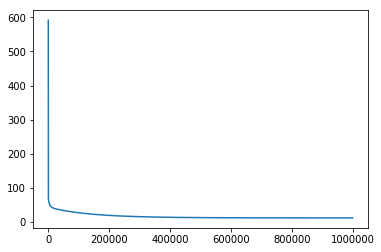

Score for Unscaled Gradient Descent =  0.645965609244


In [61]:
theta = fitNormal(X_train,Y_train.reshape(len(Y_train),1))
Y_predicted = predict(X_test,theta)
print("Score for Unscaled DF Normal Equation = ",score(Y_test,Y_predicted.reshape(len(Y_predicted))))
theta = fitGradientDescent(X_train,Y_train.reshape(len(Y_train),1),0.000006,max_iterations=1000000)
Y_predicted = predict(X_test,theta)
print("Score for Unscaled Gradient Descent = ",score(Y_test,Y_predicted.reshape(len(Y_predicted))))

Score for Scaled DF Normal Equation =  0.642994696779
Stopped after 1000001 iterations


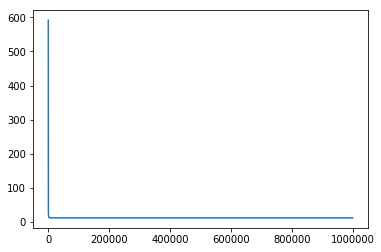

Score for Scaled Gradient Descent =  0.642994696779


In [62]:
theta = fitNormal(X_train_scaled,Y_train.reshape(len(Y_train),1))
Y_predicted = predict(X_test_scaled,theta)
print("Score for Scaled DF Normal Equation = ",score(Y_test,Y_predicted.reshape(len(Y_predicted))))
theta = fitGradientDescent(X_train_scaled,Y_train.reshape(len(Y_train),1),0.1,max_iterations=1000000) #Now we can increase learning rate as it won't cause integer overflow while multiplications
Y_predicted = predict(X_test_scaled,theta)
print("Score for Scaled Gradient Descent = ",score(Y_test,Y_predicted.reshape(len(Y_predicted))))

In [63]:
iris = Datasets.load_iris()
df = pd.DataFrame(iris.data)
list(set(iris.target))

[0, 1, 2]

# Trying Backward Elimination with StartUps Profit Dataset

In [236]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import statsmodels.formula.api as sm
from sklearn.linear_model import LinearRegression

## Data Preprocessing

- Load the data

In [268]:
data = pd.read_csv("../data/50_Startups.csv")
X = data.iloc[:,:-1].values
Y = data.iloc[:,-1].values

- Label Encoding to change strings to integers

In [269]:
labelEncoder_X = LabelEncoder()
X[:,3] = labelEncoder_X.fit_transform(X[:,3])

- One Hot Encoding to change categorical integers to dummy variables

In [270]:
oneHotEncoder = OneHotEncoder(categorical_features = [3])
X = oneHotEncoder.fit_transform(X).toarray()

 - Avoiding Dummy Variable Trap

In [271]:
#Taking one less dummy variable from each set of categorical dummy variables
X = X[:,1:]

In [272]:
X_train, X_test, Y_train, Y_test = cv.train_test_split(X,Y,test_size=0.2,random_state=0)

In [273]:
from sklearn.linear_model import LinearRegression

In [274]:
regressor = LinearRegression()
regressor.fit(X_train,Y_train)
Y_pred = regressor.predict(X_test)
score(Y_test,Y_pred) #Score with all-in model

0.93470684732824461

### Step 1

In [275]:
#Adding column of 1s for constant
X = np.append(arr = np.ones((X.shape[0],1)).astype(int),values = X,axis=1)
significance_level = 0.05

### Step 2

In [288]:
included_columns = [i for i in range(X.shape[-1])]

### Step 3 and Step 4

In [289]:
finished = False
while not finished:
    X_opt = X[:,included_columns]
    regressor_OLS = sm.OLS(endog=Y,exog=X_opt).fit()
    #print(regressor_OLS.summary())
    table_data = regressor_OLS.summary().tables[1].data
    p_values = [float(table_data[i][4]) for i in range(1,len(table_data))]
    if(max(p_values) > 0.05): 
        column_to_remove = p_values.index(max(p_values))
        #print("Removing column",included_columns[column_to_remove])
        del included_columns[column_to_remove]
    else:
        finished = True

### Step 5 

In [290]:
#Modifying X according to results of backward elimination
X = X[:,included_columns]
X_train, X_test, Y_train, Y_test = cv.train_test_split(X,Y,test_size=0.2,random_state=0)
regressor = LinearRegression()
regressor.fit(X_train,Y_train)
Y_pred = regressor.predict(X_test)
score(Y_test,Y_pred) #Score with all-in model

0.94645876077872204

In [198]:
table_data = regresser_OLS.summary().tables[1].data
p_values = [table_data[i][4] for i in range(1,len(table_data))]
p_values.index(max(p_values))

0

In [129]:
Y

array([ 192261.83,  191792.06,  191050.39,  182901.99,  166187.94,
        156991.12,  156122.51,  155752.6 ,  152211.77,  149759.96,
        146121.95,  144259.4 ,  141585.52,  134307.35,  132602.65,
        129917.04,  126992.93,  125370.37,  124266.9 ,  122776.86,
        118474.03,  111313.02,  110352.25,  108733.99,  108552.04,
        107404.34,  105733.54,  105008.31,  103282.38,  101004.64,
         99937.59,   97483.56,   97427.84,   96778.92,   96712.8 ,
         96479.51,   90708.19,   89949.14,   81229.06,   81005.76,
         78239.91,   77798.83,   71498.49,   69758.98,   65200.33,
         64926.08,   49490.75,   42559.73,   35673.41,   14681.4 ])